# Project Food Vision

In [ ]:
!pip install tensorflow==2.4.1

     |████████████████████████████████| 394.3 MB 13 kB/s 
     |████████████████████████████████| 462 kB 40.8 MB/s 
     |████████████████████████████████| 2.9 MB 34.9 MB/s 
     |████████████████████████████████| 3.8 MB 28.3 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.

In [ ]:
import tensorflow as tf
tf.__version__

'2.4.1'

## Check GPU

* We need GPU which is compatible with mixed precision traning. 
* Or we need a GPU with compute compability above 7.0.
* The Compatible one usually available in collab is **Tesla T4**.

We can still run all the code with any GPU or even without a GPU but, the benefits of mixed precision training will not be seen.


In [ ]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



Get helper functions to help with some of the small tasks such as analysing the model by looking at the training history 
The helper function module is stored on github.

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-07-24 04:55:11--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-24 04:55:11 (88.7 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [ ]:
from helper_functions import *

## Use tensorflow Datasets to download food101 dataset

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
# Check if our food101 dataset is available
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [ ]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train","validation"],# we can have test too
                                             shuffle_files=True,
                                             as_supervised=True, # as to returnn labels too
                                             with_info=True) # get some metadata

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
type(ds_info)

tensorflow_datasets.core.dataset_info.DatasetInfo

In [ ]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
train_data_one = train_data.take(1)
train_data_one

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
import matplotlib.pyplot as plt
for image, label in train_data_one:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101: {label}
  Class name: {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101: 64
  Class name: miso_soup
  


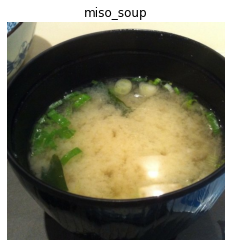

In [ ]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);


## Preprocess the data
 
Since we are using EfficientNet We dont need to rescale the data
So we need to:
* Reshape the images to same size
* Convert the dtype from int to float

In [ ]:
# make a function for preprocessing

def preprocess_img0(image,label,img_shape=224):
  """
  Convert dtype from int to float
  Reshapes image to img_shape,img_shape
  """

  image = tf.image.resize(image,[img_shape,img_shape])
  return tf.cast(image,tf.float32), label


In [ ]:
preprocessed_img = preprocess_img0(image,label)[0]
print(preprocessed_img.shape)

(224, 224, 3)


## Batch and prepare dataset

In [ ]:
# Map preprocessing fuctions to training and parallelize
train_data = train_data.map(map_func=preprocess_img0, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle data and turn it into batches
train_data = train_data.shuffle(buffer_size=1000,seed=778).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img0,num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

## Create Callbacks

We will use the following callbacks to help us train our model:
* Tensorboard callbacks to log training results
* Model Checkpoint callback to save 

In [ ]:
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## Setup mixed precision training

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") 

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build our feature extration model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

input_shape = (224,224,3)
# Create a base model
base_model = tf.keras.applications.EfficientNetB7(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape,name="Input_layer")

x = base_model(inputs,training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax",dtype=tf.float32,name="output_softmaxF32")(x)

model = tf.keras.Model(inputs,outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, None, None, 2560)  64097687  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2560)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               258661    
_________________________________________________________________
output_softmaxF32 (Activatio (None, 101)               0         
Total params: 64,356,348
Trainable params: 258,661
Non-trainable params: 64,097,687
_________________________________________________________________


## Check the layer dtypes to see if we are using mixed precisioin

In [ ]:
for layer in model.layers:
  print(layer.name,layer.trainable, layer.dtype, layer.dtype_policy)

Input_layer True float32 <Policy "float32">
efficientnetb7 False float32 <Policy "mixed_float16">
global_average_pooling2d_1 True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
output_softmaxF32 True float32 <Policy "float32">


In [ ]:
# Check dtype in efficientnet b0
for layer in model.layers[1].layers:
  print(layer.name,layer.trainable, layer.dtype, layer.dtype_policy)

input_2 False float32 <Policy "float32">
rescaling_1 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1b_dwconv False float32 <Policy "mixed_float16">
block1b_bn False float32 <Policy "

## Fit the feature extraction model

In [ ]:
history_feature_extract = model.fit(train_data,
                         epochs=3,
                         steps_per_epoch=len(train_data),
                         validation_data=test_data,
                         validation_steps=int(0.25*len(test_data)),
                         callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                experiment_name="efficientnet_b7_101_food_classes_all_data"),
                                    model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnet_b7_101_food_classes_all_data/20210724-045524
Epoch 1/3
2368/2368 [==============================] - 495s 201ms/step - loss: 2.3046 - accuracy: 0.4546 - val_loss: 1.3419 - val_accuracy: 0.6486
Epoch 2/3
2368/2368 [==============================] - 468s 197ms/step - loss: 1.4240 - accuracy: 0.6323 - val_loss: 1.2340 - val_accuracy: 0.6681
Epoch 3/3
2368/2368 [==============================] - 469s 197ms/step - loss: 1.2555 - accuracy: 0.6710 - val_loss: 1.2092 - val_accuracy: 0.6767


In [ ]:
results_feature_extract = model.evaluate(test_data)
results_feature_extract

790/790 [==============================] - 142s 180ms/step - loss: 1.2175 - accuracy: 0.6724


[1.2174714803695679, 0.6723564267158508]

## Save and load model 

In [ ]:
model.save("drive/MyDrive/models_tf/project_food101_base_model")


INFO:tensorflow:Assets written to: drive/MyDrive/models_tf/project_food101_base_model/assets


INFO:tensorflow:Assets written to: drive/MyDrive/models_tf/project_food101_base_model/assets


In [ ]:
# loading our model
model = tf.keras.models.load_model("drive/MyDrive/models_tf/project_food101_base_model")

In [ ]:
# The results of the loaded model must be almost similiar to original model
model_results = model.evaluate(test_data)
model_results

790/790 [==============================] - 143s 180ms/step - loss: 1.2175 - accuracy: 0.6724


[1.2174721956253052, 0.6723564267158508]

## Fine tuning the model for better accuracy

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, None, None, 2560)  64097687  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2560)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               258661    
_________________________________________________________________
output_softmaxF32 (Activatio (None, 101)               0         
Total params: 64,356,348
Trainable params: 64,045,621
Non-trainable params: 310,727
_________________________________________________________________


In [ ]:
# make all layers trainable in our model
for layer in model.layers:
  layer.trainable = True

In [ ]:
# Check if all layres are trainable and also see the dtype policy
for layer in model.layers:
  print(layer.name,layer.trainable,layer.dtype_policy)

Input_layer True <Policy "float32">
efficientnetb7 True <Policy "mixed_float16">
global_average_pooling2d_1 True <Policy "mixed_float16">
dense_1 True <Policy "mixed_float16">
output_softmaxF32 True <Policy "float32">


In [ ]:
# Creating a EarlyStopping callback for early stopping
# if there are no improvements in the val_loss stop the training with patience of 3 epochs
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3)

In [ ]:
# Creating learning rate reduction callback

reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                    factor=0.4,
                                                    patience=2,
                                                    verbose=1,min_lr=1e-7)

# ModelCheckpoint callback to save best model
model_ckpt = tf.keras.callbacks.ModelCheckpoint("fine_tune_checkpoints/",
                                                monitor="val_loss",
                                                save_best_only=True)

In [ ]:
# Compiling the model for fine tuning with 10X smaller learning rate

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              metrics=["accuracy"])

In [ ]:
# Fine turning all layers for 100 epochs and validating on 25% of test data

history_fine_tuned = model.fit(train_data,
                               epochs=100,
                               steps_per_epoch=len(train_data),
                               validation_data=test_data,
                               validation_steps=int(0.25*len(test_data)),
                               callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                      experiment_name="efficientnet_b7_101_food_classes_fine_tuned"),
                                          early_stopping_cb,
                                          model_ckpt,
                                          reduce_lr_cb])

Saving TensorBoard log files to: training_logs/efficientnet_b7_101_food_classes_fine_tuned/20210724-052829
Epoch 1/100
2368/2368 [==============================] - 1561s 637ms/step - loss: 1.6970 - accuracy: 0.5674 - val_loss: 1.1222 - val_accuracy: 0.6969
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


Epoch 2/100
2368/2368 [==============================] - 1507s 633ms/step - loss: 1.0953 - accuracy: 0.7075 - val_loss: 0.9358 - val_accuracy: 0.7502
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


Epoch 3/100
2368/2368 [==============================] - 1507s 633ms/step - loss: 0.8602 - accuracy: 0.7666 - val_loss: 0.8535 - val_accuracy: 0.7698
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


Epoch 4/100
2368/2368 [==============================] - 1505s 633ms/step - loss: 0.7304 - accuracy: 0.7948 - val_loss: 0.9415 - val_accuracy: 0.7549
Epoch 5/100
2368/2368 [==============================] - 1504s 632ms/step - loss: 0.6979 - accuracy: 0.8028 - val_loss: 0.8885 - val_accuracy: 0.7625

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/100
2368/2368 [==============================] - 1501s 630ms/step - loss: 0.3154 - accuracy: 0.9081 - val_loss: 0.7236 - val_accuracy: 0.8258
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


Epoch 7/100
2368/2368 [==============================] - 1500s 630ms/step - loss: 0.1111 - accuracy: 0.9657 - val_loss: 0.8215 - val_accuracy: 0.8174
Epoch 8/100
2368/2368 [==============================] - 1506s 632ms/step - loss: 0.0928 - accuracy: 0.9705 - val_loss: 0.8927 - val_accuracy: 0.8181

Epoch 00008: ReduceLROnPlateau reducing learning rate to 8.000000379979611e-05.
Epoch 9/100
2368/2368 [==============================] - 1506s 632ms/step - loss: 0.0312 - accuracy: 0.9905 - val_loss: 1.0478 - val_accuracy: 0.8342


In [ ]:
# We can see we acheived 99.05 percent of accuracy on test data

In [ ]:
results_fine_tuned = model.evaluate(test_data)
results_fine_tuned

790/790 [==============================] - 147s 182ms/step - loss: 1.0906 - accuracy: 0.8297


[1.0905838012695312, 0.8297425508499146]

In [ ]:
## We can see we acheived 82.97% accuracy on test data

In [ ]:
# Save  the model in drive
model = tf.keras.models.load_model("drive/MyDrive/models_tf/project_food101_fine_tuned_model")


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
